In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv
/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv


In [2]:
! pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=903026 sha256=36036d9285efcf0338e1dcb2dc384fa0956b48be73f49d2c73f711d45a4491cf
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


# Github connection 

In [3]:
!pip install PyGithub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 7.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 69.0 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/LorenzoBozzoni/RecSys_Challenge_Polimi_2024.git

Cloning into 'RecSys_Challenge_Polimi_2024'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 204 (delta 51), reused 181 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (204/204), 8.17 MiB | 24.10 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'RecSys_Challenge_Polimi_2024':
        repo = r
        print('Repository found')

Repository found


## Commit and push some specific file

In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
        print('Commit and push completed successfully')
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())
        print(f'Exception {Exception} while trying to committing')

In [7]:
%cd /kaggle/working/RecSys_Challenge_Polimi_2024

/kaggle/working/RecSys_Challenge_Polimi_2024


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [8]:
#upload_file('/kaggle/working/RecSys_Challenge_Polimi_2024/recsys-challenge-2024.ipynb', './recsys-challenge-2024.ipynb', 'adding github connection from kaggle')

# Data exploration 
## URM
The URM contains a user for each row and an item for each column

In [9]:
URM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv")
URM_all_dataframe.head(10)

,user_id,item_id,data
0,0,0,1.0
1,0,2,1.0
2,0,120,1.0
3,0,128,1.0
4,0,211,1.0
5,0,232,1.0
6,0,282,1.0
7,0,453,1.0
8,0,458,1.0
9,0,491,1.0


In [10]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

The number of interactions is 1764607


In [11]:
userID_unique = URM_all_dataframe["user_id"].unique()
itemID_unique = URM_all_dataframe["item_id"].unique()
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))

Number of items	 38121, Number of users	 35736
Max ID items	 38120, Max Id users	 35735



In [12]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["user_id"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["item_id"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [13]:
original_item_ID = 292
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))
URM_all_dataframe.head(n=10)

New index for item 292 is 17024


,user_id,item_id,data
0,0,0,1.0
1,0,2,1.0
2,0,120,1.0
3,0,128,1.0
4,0,211,1.0
5,0,232,1.0
6,0,282,1.0
7,0,453,1.0
8,0,458,1.0
9,0,491,1.0


In [14]:
URM_all_dataframe["user_id"] = URM_all_dataframe["user_id"].map(user_original_ID_to_index)
URM_all_dataframe["item_id"] = URM_all_dataframe["item_id"].map(item_original_ID_to_index)

In [15]:
URM_all_dataframe.head(n=10)

,user_id,item_id,data
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
5,0,5,1.0
6,0,6,1.0
7,0,7,1.0
8,0,8,1.0
9,0,9,1.0


In [16]:
userID_unique = URM_all_dataframe["user_id"].unique()
itemID_unique = URM_all_dataframe["item_id"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))


Number of items	 38121, Number of users	 35736
Max ID items	 38120, Max Id users	 35735

Average interactions per user 49.38
Average interactions per item 46.29

Sparsity 99.87 %


In [17]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["data"].values, 
                          (URM_all_dataframe["user_id"].values, URM_all_dataframe["item_id"].values)))

URM_all

<COOrdinate sparse matrix of dtype 'float64'
	with 1764607 stored elements and shape (35736, 38121)>

In [18]:
URM_all.tocsr()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1764607 stored elements and shape (35736, 38121)>

In [19]:
item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity = np.sort(item_popularity)
item_popularity

array([  12,   13,   13, ..., 1254, 1310, 1470], dtype=int32)

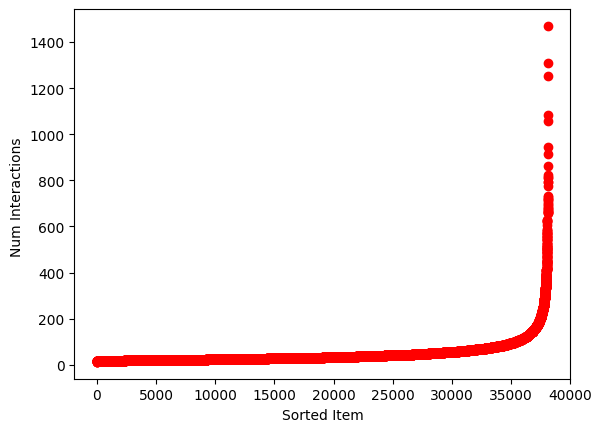

In [20]:
plt.plot(item_popularity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted Item')
plt.show()

In [21]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 46.29
Average per-item interactions for the top 10% popular items 153.63
Average per-item interactions for the least 10% popular items 17.95
Average per-item interactions for the median 10% popular items 31.50


In [22]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


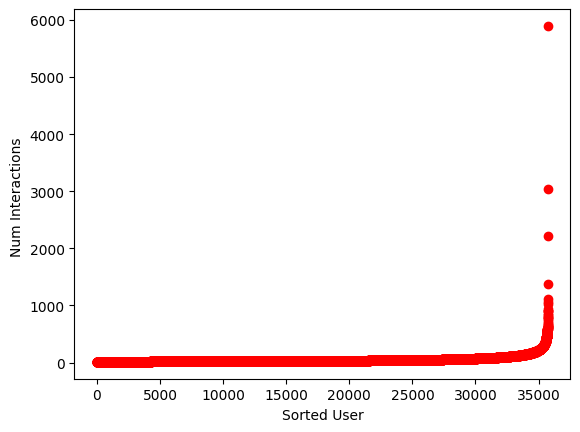

In [23]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


plt.plot(user_activity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted User')
plt.show()

## ICM
The ICM has one item for each row and one feature for each column

In [24]:
ICM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv")
ICM_all_dataframe.head(10)

,item_id,feature_id,data
0,2519,0,1.0
1,2642,0,1.0
2,3316,0,1.0
3,3400,0,1.0
4,3472,0,1.0
5,4361,0,1.0
6,4661,0,1.0
7,8697,0,1.0
8,9692,0,1.0
9,9693,0,1.0


In [25]:
featureID_unique = ICM_all_dataframe["feature_id"].unique()
itemID_unique_ICM = ICM_all_dataframe["item_id"].unique()

In [26]:
n_features = len(featureID_unique)
n_items_ICM = len(itemID_unique_ICM)
n_interactions_ICM = len(ICM_all_dataframe)

print ("Number of items\t {}, Number of features\t {}".format(n_items_ICM, n_features))
print ("Max ID items\t {}, Max Id features\t {}\n".format(max(itemID_unique_ICM), max(featureID_unique)))

Number of items	 38121, Number of features	 94331
Max ID items	 38120, Max Id features	 94330



In [27]:
mapped_id, original_id = pd.factorize(ICM_all_dataframe["feature_id"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(ICM_all_dataframe["item_id"].unique())
item_original_ID_to_index_ICM = pd.Series(mapped_id, index=original_id)

In [28]:
ICM_all_dataframe["feature_id"] = ICM_all_dataframe["feature_id"].map(feature_original_ID_to_index)
ICM_all_dataframe["item_id"] = ICM_all_dataframe["item_id"].map(item_original_ID_to_index_ICM)

In [29]:
ICM_all_dataframe.head(n=10)

,item_id,feature_id,data
0,0,0,1.0
1,1,0,1.0
2,2,0,1.0
3,3,0,1.0
4,4,0,1.0
5,5,0,1.0
6,6,0,1.0
7,7,0,1.0
8,8,0,1.0
9,9,0,1.0


In [30]:
featureID_unique = ICM_all_dataframe["feature_id"].unique()
itemID_unique_ICM = ICM_all_dataframe["item_id"].unique()

n_features = len(featureID_unique)
n_items_ICM = len(itemID_unique_ICM)
n_interactions_ICM = len(ICM_all_dataframe)

print ("Number of items\t {}, Number of features\t {}".format(n_items_ICM, n_features))
print ("Max ID items\t {}, Max Id features\t {}\n".format(max(itemID_unique_ICM), max(featureID_unique)))
print ("Average interactions per feature {:.2f}".format(n_interactions_ICM/n_features))
print ("Average interactions per item {:.2f}\n".format(n_interactions_ICM/n_items_ICM))

print ("Sparsity {:.2f} %".format((1-float(n_interactions_ICM)/(n_items_ICM*n_features))*100))


Number of items	 38121, Number of features	 94331
Max ID items	 38120, Max Id features	 94330

Average interactions per feature 31.17
Average interactions per item 77.12

Sparsity 99.92 %


In [31]:
ICM_all = sps.coo_matrix((ICM_all_dataframe["data"].values, (ICM_all_dataframe["item_id"].values,ICM_all_dataframe["feature_id"].values)))


ICM_all

<COOrdinate sparse matrix of dtype 'float64'
	with 2940040 stored elements and shape (38121, 94331)>

In [32]:
ICM_all.tocsr()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2940040 stored elements and shape (38121, 94331)>

In [33]:
item_popularity_ICM = np.ediff1d(ICM_all.tocsr().indptr)       # tocsc(), when rows and columns inverted
item_popularity_ICM = np.sort(item_popularity_ICM)
item_popularity_ICM 

array([   1,    1,    1, ..., 1084, 1199, 2013], dtype=int32)

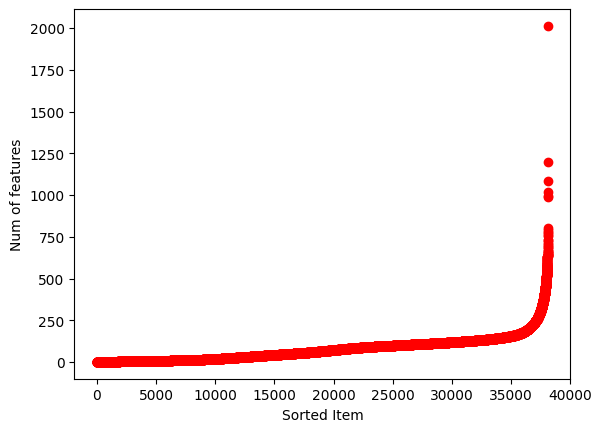

In [34]:
plt.plot(item_popularity_ICM, 'ro')
plt.ylabel('Num of features')
plt.xlabel('Sorted Item')
plt.show()

In [35]:
ten_percent = int(n_items_ICM/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity_ICM.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity_ICM[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity_ICM[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity_ICM[int(n_items_ICM*0.45):int(n_items_ICM*0.55)].mean()))

Average per-item interactions over the whole dataset 77.12
Average per-item interactions for the top 10% popular items 228.64
Average per-item interactions for the least 10% popular items 3.77
Average per-item interactions for the median 10% popular items 65.90


# Creating a validation set for testing our recommendation models

In [36]:
%cd /kaggle/working/RecSys_Challenge_Polimi_2024

/kaggle/working/RecSys_Challenge_Polimi_2024


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [37]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout

In [38]:
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 164 ( 0.5%) Users that have less than 1 test interactions


# Tuning hyperparameters

In [39]:
!pwd

/kaggle/working/RecSys_Challenge_Polimi_2024


In [40]:
from tqdm import tqdm

In [41]:
! python run_compile_all_cython.py

run_compile_all_cython: Found 11 Cython files in 5 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/usr/local/bin/python'
Compiling [1/11]: MatrixFactorization_Cython_Epoch.pyx... 
Traceback (most recent call last):
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/CythonCompiler/compile_script.py", line 24, in <module>
    from Cython.Distutils import build_ext
ModuleNotFoundError: No module named 'Cython'
Traceback (most recent call last):
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/run_compile_all_cython.py", line 60, in <module>
    run_compile_subprocess(file_path, [file_name])
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/CythonCompiler/run_compile_subprocess.py", line 51, in run_compile_subprocess
    raise exc
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/CythonCompiler/run_compile_subprocess.py", line 32, in run_compile_subprocess
    output = subprocess.check_output(' '.join(command),
  File "/usr

In [46]:
! pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 22/11/17

@author: Maurizio Ferrari Dacrema
"""

from Recommenders.Recommender_import_list import *

import traceback

import os, multiprocessing
from functools import partial



from Data_manager.Movielens.Movielens1MReader import Movielens1MReader
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

from HyperparameterTuning.run_hyperparameter_search import runHyperparameterSearch_Collaborative, runHyperparameterSearch_Content, runHyperparameterSearch_Hybrid


def read_data_split_and_search():
    """
    This function provides a simple example on how to tune parameters of a given algorithm

    The BayesianSearch object will save:
        - A .txt file with all the cases explored and the recommendation quality
        - A _best_model file which contains the trained model and can be loaded with recommender.load_model()
        - A _best_parameter file which contains a dictionary with all the fit parameters, it can be passed to recommender.fit(**_best_parameter)
        - A _best_result_validation file which contains a dictionary with the results of the best solution on the validation
        - A _best_result_test file which contains a dictionary with the results, on the test set, of the best solution chosen using the validation set
    """



    #dataReader = Movielens1MReader()
    #dataset = dataReader.load_data()

    URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
    URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

    output_folder_path = "result_experiments/"


    # If directory does not exist, create
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)


    collaborative_algorithm_list = [
        Random,
        TopPop,
        P3alphaRecommender,
        RP3betaRecommender,
        ItemKNNCFRecommender,
        UserKNNCFRecommender,
        MatrixFactorization_BPR_Cython,
        #MatrixFactorization_FunkSVD_Cython,
        PureSVDRecommender,
        SLIM_BPR_Cython,
        SLIMElasticNetRecommender
    ]




    from Evaluation.Evaluator import EvaluatorHoldout

    cutoff_list = [5, 10, 20]
    metric_to_optimize = "MAP"
    cutoff_to_optimize = 10

    n_cases = 10
    n_random_starts = int(n_cases/3)

    evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list = cutoff_list)
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list = cutoff_list)


    runParameterSearch_Collaborative_partial = partial(runHyperparameterSearch_Collaborative,
                                                       URM_train = URM_train,
                                                       metric_to_optimize = metric_to_optimize,
                                                       cutoff_to_optimize = cutoff_to_optimize,
                                                       n_cases = n_cases,
                                                       n_random_starts = n_random_starts,
                                                       evaluator_validation_earlystopping = evaluator_validation,
                                                       evaluator_validation = evaluator_validation,
                                                       evaluator_test = evaluator_test,
                                                       output_folder_path = output_folder_path,
                                                       resume_from_saved = True,
                                                       similarity_type_list = ["cosine"],
                                                       parallelizeKNN = False)





    pool = multiprocessing.Pool(processes=int(multiprocessing.cpu_count()), maxtasksperchild=1)
    pool.map(runParameterSearch_Collaborative_partial, collaborative_algorithm_list)

    #
    #
    # for recommender_class in collaborative_algorithm_list:
    #
    #     try:
    #
    #         runParameterSearch_Collaborative_partial(recommender_class)
    #
    #     except Exception as e:
    #
    #         print("On recommender {} Exception {}".format(recommender_class, str(e)))
    #         traceback.print_exc()
    #




    ################################################################################################
    ###### Content Baselines


    
    #for ICM_name, ICM_object in dataset.get_loaded_ICM_dict().items():
    ICM_name = "ICM_standard"
    ICM_object = ICM_all
    try:

        runHyperparameterSearch_Content(ItemKNNCBFRecommender,
                                    URM_train = URM_train,
                                    URM_train_last_test = URM_train + URM_validation,
                                    metric_to_optimize = metric_to_optimize,
                                    cutoff_to_optimize = cutoff_to_optimize,
                                    evaluator_validation = evaluator_validation,
                                    evaluator_test = evaluator_test,
                                    output_folder_path = output_folder_path,
                                    parallelizeKNN = True,
                                    allow_weighting = True,
                                    resume_from_saved = True,
                                    similarity_type_list = ["cosine"],
                                    ICM_name = ICM_name,
                                    ICM_object = ICM_object.copy(),
                                    n_cases = n_cases,
                                    n_random_starts = n_random_starts)

    except Exception as e:

        print("On CBF recommender for ICM {} Exception {}".format(ICM_name, str(e)))
        traceback.print_exc()


    try:

        runHyperparameterSearch_Hybrid(ItemKNN_CFCBF_Hybrid_Recommender,
                                    URM_train = URM_train,
                                    URM_train_last_test = URM_train + URM_validation,
                                    metric_to_optimize = metric_to_optimize,
                                    cutoff_to_optimize = cutoff_to_optimize,
                                    evaluator_validation = evaluator_validation,
                                    evaluator_test = evaluator_test,
                                    output_folder_path = output_folder_path,
                                    parallelizeKNN = True,
                                    allow_weighting = True,
                                    resume_from_saved = True,
                                    similarity_type_list = ["cosine"],
                                    ICM_name = ICM_name,
                                    ICM_object = ICM_object.copy(),
                                    n_cases = n_cases,
                                    n_random_starts = n_random_starts)


    except Exception as e:

            print("On recommender {} Exception {}".format(ItemKNN_CFCBF_Hybrid_Recommender, str(e)))
            traceback.print_exc()





if __name__ == '__main__':


    read_data_split_and_search()


EvaluatorHoldout: Ignoring 431 ( 1.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 139 ( 0.4%) Users that have less than 1 test interactions
SearchSingleCase: Resuming 'RandomRecommender' Failed, no such file exists.

SearchSingleCase: Testing config: {}
EvaluatorHoldout: Processed 35305 (100.0%) in 1.00 min. Users per second: 586
SearchSingleCase: New best config found. Config 0: {} - results: PRECISION: 0.0001898, PRECISION_RECALL_MIN_DEN: 0.0002730, RECALL: 0.0002211, MAP: 0.0000575, MAP_MIN_DEN: 0.0000828, MRR: 0.0005747, NDCG: 0.0002357, F1: 0.0002043, HIT_RATE: 0.0018977, ARHR_ALL_HITS: 0.0005747, NOVELTY: 0.0040879, AVERAGE_POPULARITY: 0.0317050, DIVERSITY_MEAN_INTER_LIST: 0.9997378, DIVERSITY_HERFINDAHL: 0.9999709, COVERAGE_ITEM: 0.9998688, COVERAGE_ITEM_HIT: 0.0017313, ITEMS_IN_GT: 0.9887988, COVERAGE_USER: 0.9879393, COVERAGE_USER_HIT: 0.0018749, USERS_IN_GT: 0.9879393, DIVERSITY_GINI: 0.8162567, SHANNON_ENTROPY: 15.1390829, RATIO_DIVERSITY_HERFIN

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/pandas/compat/_optional.py", line 135, in import_optional_dependency
    module = importlib.import_module(name)
  File "/usr/local/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1004, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'tables'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/HyperparameterTuning/run_hyperparameter_search.py", line 665, in runHyperparameterSearch_Collaborative
    hyperparameterSearch.search(recommender_input_args,
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/HyperparameterTuning/Search

SearchBayesianSkopt: Resuming 'ItemKNNCBFRecommender_ICM_standard_cosine' Failed, no such file exists.

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 714, 'shrink': 283, 'similarity': 'cosine', 'normalize': False, 'feature_weighting': 'BM25'}
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 358.62 column/sec. Elapsed time 1.77 min
EvaluatorHoldout: Processed 35305 (100.0%) in 1.08 min. Users per second: 546
SearchBayesianSkopt: New best config found. Config 0: {'topK': 714, 'shrink': 283, 'similarity': 'cosine', 'normalize': False, 'feature_weighting': 'BM25'} - results: PRECISION: 0.0017051, PRECISION_RECALL_MIN_DEN: 0.0026389, RECALL: 0.0021437, MAP: 0.0006377, MAP_MIN_DEN: 0.0010128, MRR: 0.0056517, NDCG: 0.0024216, F1: 0.0018994, HIT_RATE: 0.0153519, ARHR_ALL_HITS: 0.0059598, NOVELTY: 0.0040773, AVERAGE_POPULARITY: 0.0330076, DIVERSITY_MEAN_INTER_LIST: 0.9980129, DIVERSITY_H

multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/pandas/compat/_optional.py", line 135, in import_optional_dependency
    module = importlib.import_module(name)
  File "/usr/local/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1004, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'tables'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/kaggle/work

SearchBayesianSkopt: Resuming 'ItemKNN_CFCBF_HybridRecommender_ICM_standard_cosine' Failed, no such file exists.

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 887, 'shrink': 543, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'none', 'ICM_weight': 0.6703995722553515}
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 284.07 column/sec. Elapsed time 2.24 min
EvaluatorHoldout: Processed 35305 (100.0%) in 1.09 min. Users per second: 538
SearchBayesianSkopt: New best config found. Config 0: {'topK': 887, 'shrink': 543, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'none', 'ICM_weight': 0.6703995722553515} - results: PRECISION: 0.0354341, PRECISION_RECALL_MIN_DEN: 0.0643767, RECALL: 0.0586956, MAP: 0.0157000, MAP_MIN_DEN: 0.0285204, MRR: 0.1155907, NDCG: 0.0577570, F1: 0.0441906, HIT_RATE: 0.2625124, ARHR_ALL_HITS: 0.1340065, NOVELTY: 0.0035019, AVER